#### Importowanie bibliotek

In [1]:
import pandas as pd
import numpy as np
from scipy.cluster import hierarchy
import seaborn as sns

import matplotlib.pyplot as plt

sns.set_style("darkgrid")

#### Wczytanie zbioru danych

In [ ]:
df = pd.read_excel("../Tabela 1.xlsx")

In [4]:
df.head()

,Name,Exposure,class,Chemical,SEX (M/F),Gen1,Gen2,Gen3,Gen4,Gen5,...,Gen2971,Gen2972,Gen2973,Gen2974,Gen2975,Gen2976,Gen2977,Gen2978,Gen2979,Gen2980
0,Sample1,Control,C(M),Control,M,1.126636,0.982482,0.965753,0.795236,1.093474,...,1.943480,2.059138,0.560137,1.073068,1.864937,0.949825,2.004953,1.894345,1.801144,2.116696
1,Sample2,Control,C(M),Control,M,1.102942,0.792857,0.842533,0.704507,0.803609,...,1.933369,1.939796,1.226766,1.118514,1.815777,0.846754,1.921322,1.782817,1.704406,2.068778
2,Sample3,Control,C(M),Control,M,1.129240,0.989232,0.974295,0.771200,0.970926,...,1.919848,2.077602,1.084620,1.089832,1.825995,1.043954,1.998114,1.845221,1.728693,2.097107
3,Sample4,Control,C(M),Control,M,1.100176,1.010291,0.802952,0.696876,0.617705,...,1.941300,2.034530,1.401092,1.067069,1.814479,0.860357,2.041024,1.772065,1.633040,2.052009
4,Sample5,Control,C(M),Control,M,1.052659,1.033912,0.697614,1.229266,0.642373,...,1.933198,1.920972,0.971900,1.132778,1.831693,0.872452,1.849572,1.798413,1.777406,1.989491


#### Analiza HCA

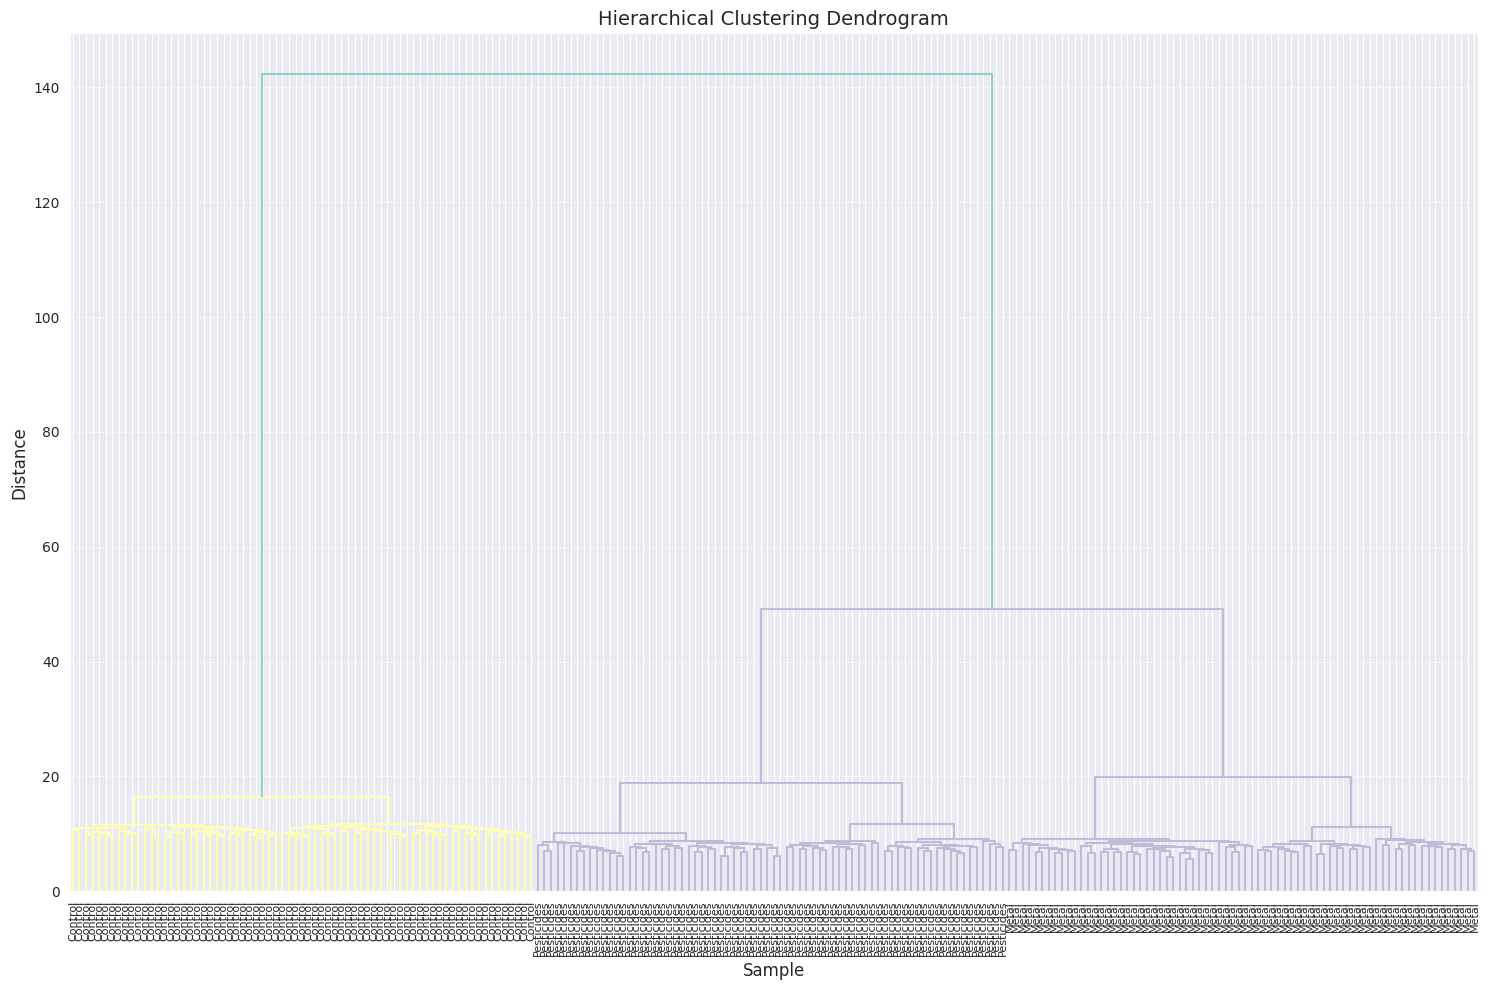

In [7]:
# Prepare data for clustering (exclude non-numeric columns)
data_for_clustering = df.select_dtypes(include=['float64'])

# Compute the linkage matrix
linkage_matrix = hierarchy.linkage(data_for_clustering, method='ward', metric='euclidean')

# Create figure with larger size
plt.figure(figsize=(15, 10))

# Create dendrogram with improved formatting
dendrogram = hierarchy.dendrogram(
    linkage_matrix, 
    leaf_rotation=90,
    leaf_font_size=8,
    labels=df['Exposure'].values,
    orientation='top'  # Put labels at the bottom
)

plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
plt.xlabel('Sample', fontsize=12)
plt.ylabel('Distance', fontsize=12)

# Increase bottom margin to give more space for labels
plt.subplots_adjust(bottom=0.25)

# Make the plot more readable
plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=10)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

#### Odcięcie drzewa na 0.7 wysokości

Number of clusters at 70% threshold: 2

Samples per cluster:
Cluster
1     71
2    144
Name: count, dtype: int64


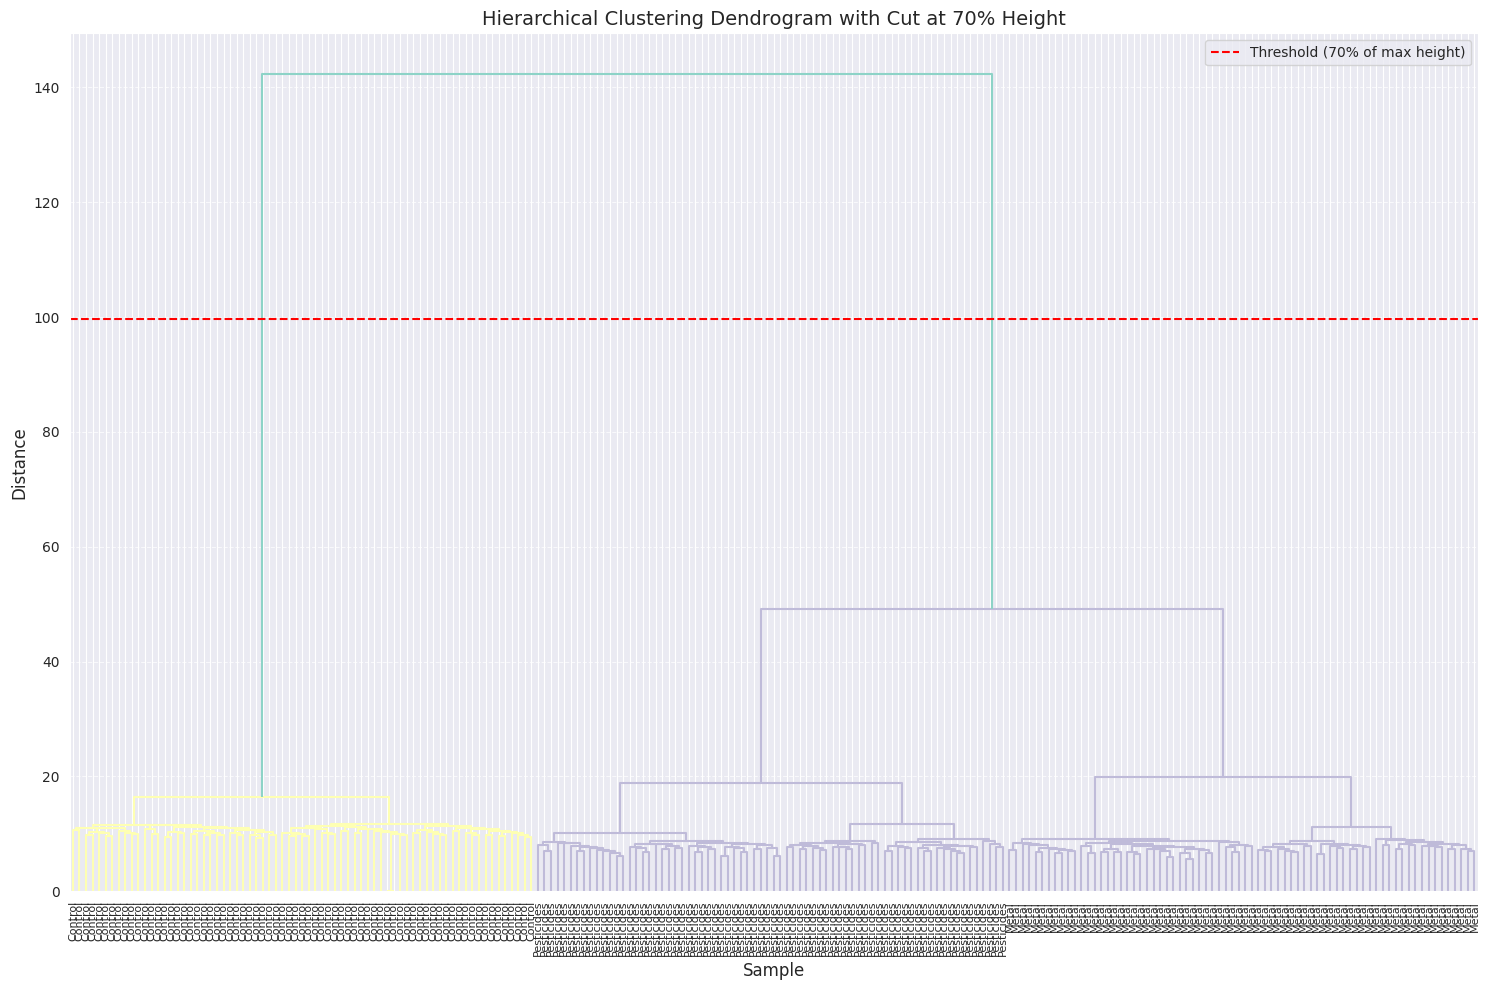

In [8]:
# Calculate the maximum height (distance) in the dendrogram
max_height = max(linkage_matrix[:, 2])
threshold_height = 0.7 * max_height

# Cut the tree at 70% of the maximum height
clusters = hierarchy.fcluster(linkage_matrix, t=threshold_height, criterion='distance')

# Get number of clusters
num_clusters = len(np.unique(clusters))
print(f"Number of clusters at 70% threshold: {num_clusters}")

# Create a new figure
plt.figure(figsize=(15, 10))

# Plot the dendrogram with a horizontal line showing the cut
dendrogram = hierarchy.dendrogram(
    linkage_matrix,
    leaf_rotation=90,
    leaf_font_size=8,
    labels=df['Exposure'].values,
    orientation='top',
    color_threshold=threshold_height  # Colors clusters below the threshold
)

# Add a horizontal line at the threshold
plt.axhline(y=threshold_height, color='r', linestyle='--', label=f'Threshold (70% of max height)')

plt.title('Hierarchical Clustering Dendrogram with Cut at 70% Height', fontsize=14)
plt.xlabel('Sample', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.legend()

# Increase bottom margin for labels
plt.subplots_adjust(bottom=0.25)

# Make the plot more readable
plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=10)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Create a dataframe with cluster assignments
cluster_df = pd.DataFrame({
    'Exposure': df['Exposure'],
    'Cluster': clusters
})

# Count samples per cluster
cluster_counts = cluster_df['Cluster'].value_counts().sort_index()
print("\nSamples per cluster:")
print(cluster_counts)

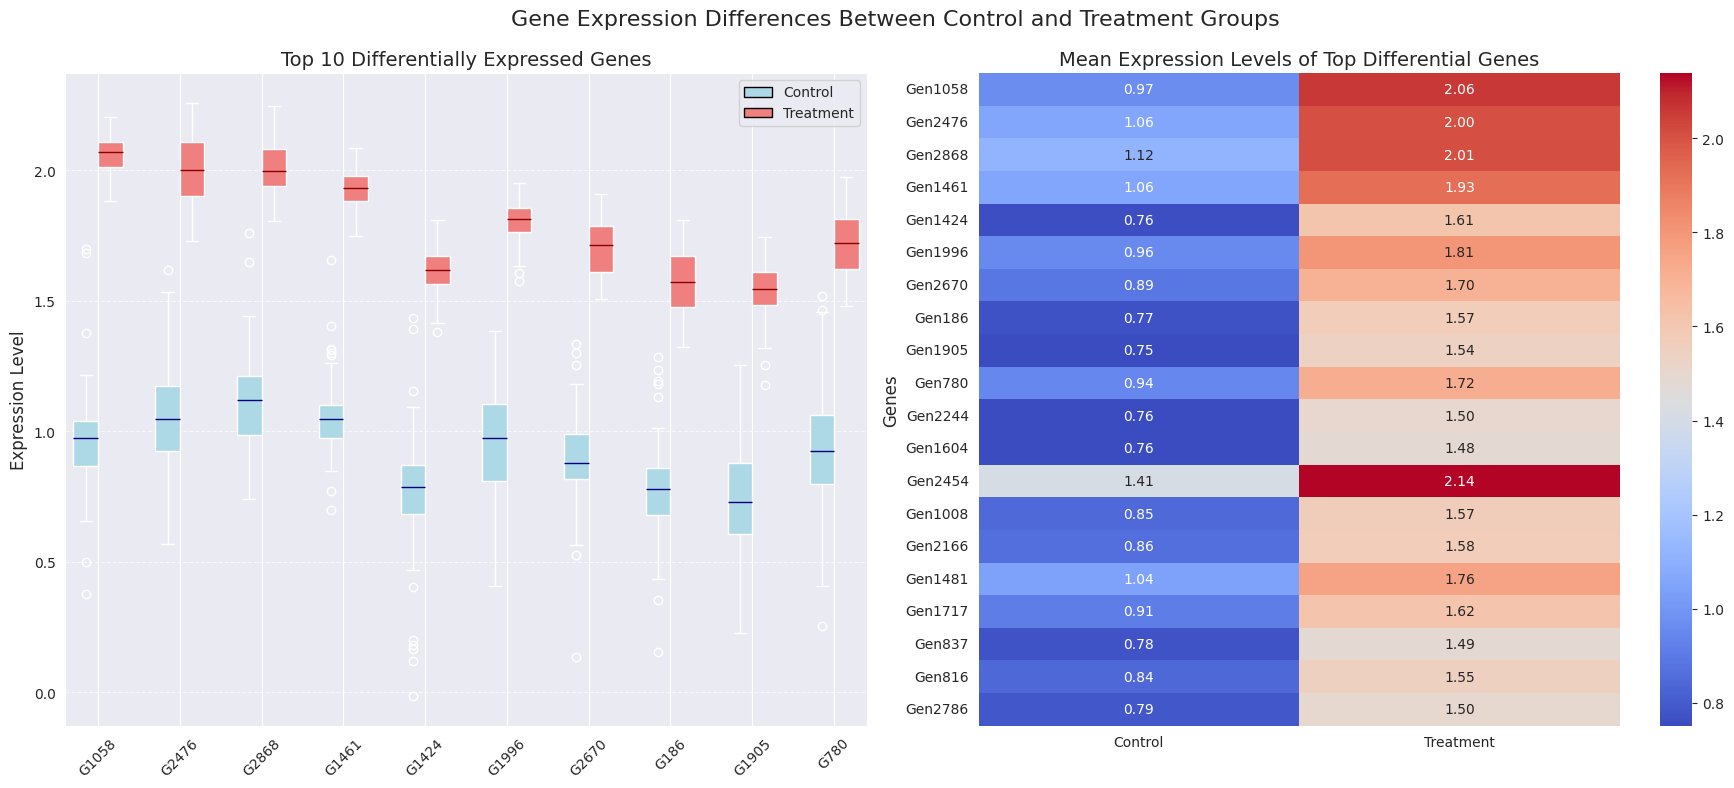

Fold changes (Treatment/Control) for top differential genes:
Gen1058: 2.13
Gen2476: 1.89
Gen2868: 1.80
Gen1461: 1.83
Gen1424: 2.12
Gen1996: 1.89
Gen2670: 1.91
Gen186: 2.04
Gen1905: 2.05
Gen780: 1.82
Gen2244: 1.99
Gen1604: 1.96
Gen2454: 1.52
Gen1008: 1.85
Gen2166: 1.83
Gen1481: 1.68
Gen1717: 1.78
Gen837: 1.92
Gen816: 1.84
Gen2786: 1.90


In [10]:
from matplotlib.patches import Patch

# Create a new column for simplified group classification
df['Group'] = df['Exposure'].apply(lambda x: 'Control' if x == 'Control' else 'Treatment')

# Select only numeric columns (gene expression data)
gene_data = df.select_dtypes(include=['float64'])

# Calculate mean expression for each gene by group
control_means = df[df['Group'] == 'Control'][gene_data.columns].mean()
treatment_means = df[df['Group'] == 'Treatment'][gene_data.columns].mean()

# Find genes with the most significant differences between groups
diff_means = abs(control_means - treatment_means)
top_diff_genes = diff_means.nlargest(20).index.tolist()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# 1. Box plot for top differential genes
for i, gene in enumerate(top_diff_genes[:10]):  # Use top 10 genes for clearer visualization
    # Plot control boxes
    control_data = df[df['Group'] == 'Control'][gene]
    treatment_data = df[df['Group'] == 'Treatment'][gene]
    
    bp1 = ax1.boxplot([control_data], positions=[i*2-0.3], widths=0.6, patch_artist=True, 
                     boxprops=dict(facecolor='lightblue'), medianprops=dict(color='navy'))
    bp2 = ax1.boxplot([treatment_data], positions=[i*2+0.3], widths=0.6, patch_artist=True, 
                     boxprops=dict(facecolor='lightcoral'), medianprops=dict(color='darkred'))

# Set boxplot formatting
ax1.set_xticks(range(0, 20, 2))
ax1.set_xticklabels([gene.replace('Gen', 'G') for gene in top_diff_genes[:10]], rotation=45)
ax1.set_title('Top 10 Differentially Expressed Genes', fontsize=14)
ax1.set_ylabel('Expression Level', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Create a custom legend
legend_elements = [Patch(facecolor='lightblue', edgecolor='black', label='Control'),
                  Patch(facecolor='lightcoral', edgecolor='black', label='Treatment')]
ax1.legend(handles=legend_elements, loc='upper right')

# 2. Heatmap of gene expression differences
gene_diff_df = pd.DataFrame({
    'Control': control_means[top_diff_genes],
    'Treatment': treatment_means[top_diff_genes]
})

sns.heatmap(gene_diff_df, cmap='coolwarm', annot=True, fmt='.2f', ax=ax2)
ax2.set_title('Mean Expression Levels of Top Differential Genes', fontsize=14)
ax2.set_ylabel('Genes', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.suptitle('Gene Expression Differences Between Control and Treatment Groups', fontsize=16)
plt.subplots_adjust(top=0.9)

# Show plot
plt.show()

# Print fold changes for top differential genes
fold_changes = treatment_means[top_diff_genes] / control_means[top_diff_genes]
print("Fold changes (Treatment/Control) for top differential genes:")
for gene, fc in zip(top_diff_genes, fold_changes):
    print(f"{gene}: {fc:.2f}")

Wyniki analizy HCA wskazują na to, że jest istotna różnica pomiędzy grupą kontrolną a grupą badaną. Obie grupy tworzą osobny klaster. Dodatkowo widać, że różnica pomiędzy obiektami poddanymi pestycydom i metalom jest również znacząca.

Widać, że grupa badana wykazuje się wyższą ekspresją genów w stosunku do grupy kontrolnej.